In [27]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from time import time
con = create_engine(os.environ['dw_uri'], echo=False).raw_connection()

In [46]:
currency = "GBP"
sql = "select * \
       from rates \
       where \
        currency = %(currency)s \
        and date between %(start)s and %(end)s"
df = pd.read_sql(sql,con,
                 params={'currency':currency,
                         'start':'2016-01-01',
                         'end':'2017-03-20'},index_col='date',parse_dates=['date'])

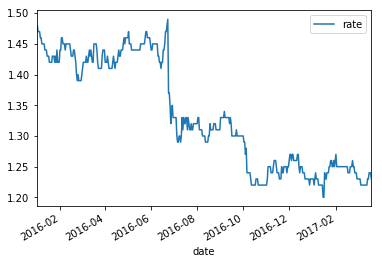

In [47]:
df.head()
df.plot()